In [2]:
# Cell 1: Setup
# Load core libraries (Tidyverse includes ggplot2, dplyr, readr)
library(tidyverse)
library(survival)
library(corrplot)

print("Environment Ready! (Skipped broken survminer package)")

corrplot 0.95 loaded



[1] "Environment Ready! (Skipped broken survminer package)"


In [8]:
# Cell 1: Setup
# Load core libraries (Tidyverse includes ggplot2, dplyr, readr)
library(tidyverse)
library(survival)
library(corrplot)

print("Environment Ready! (Skipped broken survminer package)")

[1] "Environment Ready! (Skipped broken survminer package)"


In [10]:
# Cell 2: Data Ingestion (FIXED)
# Load data from parent directory
data_path <- "/content/train_FD001.txt"

# Check if file exists before reading
if (!file.exists(data_path)) {
  stop("Error: File not found at ../train_FD001.txt")
}

# Read table
raw_data <- read.table(data_path, header = FALSE)

# CRITICAL FIX: The file has trailing spaces that look like extra columns.
# We strictly keep only the first 26 columns and discard the rest.
raw_data <- raw_data[, 1:26]

# Assign column names
col_names <- c("unit_id", "cycle", "setting_1", "setting_2", "setting_3",
               "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10",
               "s11", "s12", "s13", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21")
colnames(raw_data) <- col_names

# Check the output - should be exactly 26 columns now
print(paste("Number of columns:", ncol(raw_data)))
head(raw_data)

[1] "Number of columns: 26"


unit_id cycle setting_1 setting_2 setting_3 s1     s2     s3      s4     
1 1       1     -0.0007   -4e-04    100       518.67 641.82 1589.70 1400.60
2 1       2      0.0019   -3e-04    100       518.67 642.15 1591.82 1403.14
3 1       3     -0.0043    3e-04    100       518.67 642.35 1587.99 1404.20
4 1       4      0.0007    0e+00    100       518.67 642.35 1582.79 1401.87
5 1       5     -0.0019   -2e-04    100       518.67 642.37 1582.85 1406.22
6 1       6     -0.0043   -1e-04    100       518.67 642.10 1584.47 1398.37
  s5    ⋯ s12    s13     s14     s15    s16  s17 s18  s19 s20   s21    
1 14.62 ⋯ 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100 39.06 23.4190
2 14.62 ⋯ 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100 39.00 23.4236
3 14.62 ⋯ 522.42 2388.03 8133.23 8.4178 0.03 390 2388 100 38.95 23.3442
4 14.62 ⋯ 522.86 2388.08 8133.83 8.3682 0.03 392 2388 100 38.88 23.3739
5 14.62 ⋯ 522.19 2388.04 8133.80 8.4294 0.03 393 2388 100 38.90 23.4044
6 14.62 ⋯ 521.68 2388.03 8132.85 8.4108 0.03 391 2388 100 38.98 23.3669

In [11]:
# Cell 3: Feature Engineering
# Create data_clean with RUL and failed flag
data_clean <- raw_data %>%
  group_by(unit_id) %>%
  mutate(max_cycle = max(cycle),
         RUL = max_cycle - cycle,
         failed = ifelse(RUL == 0, 1, 0)) %>%
  ungroup()

# Filter out constant sensors and settings columns
# Dropping s1, s5, s10, s16, s18, s19 and settings
cols_to_drop <- c("s1", "s5", "s10", "s16", "s18", "s19", "setting_1", "setting_2", "setting_3")
data_clean <- data_clean %>%
  select(-all_of(cols_to_drop))

# Preview the clean data
head(data_clean)

unit_id cycle s2     s3      s4      s6    s7     s8      s9      s11  
1 1       1     641.82 1589.70 1400.60 21.61 554.36 2388.06 9046.19 47.47
2 1       2     642.15 1591.82 1403.14 21.61 553.75 2388.04 9044.07 47.49
3 1       3     642.35 1587.99 1404.20 21.61 554.26 2388.08 9052.94 47.27
4 1       4     642.35 1582.79 1401.87 21.61 554.45 2388.11 9049.48 47.13
5 1       5     642.37 1582.85 1406.22 21.61 554.00 2388.06 9055.15 47.28
6 1       6     642.10 1584.47 1398.37 21.61 554.67 2388.02 9049.68 47.16
  s12    s13     s14     s15    s17 s20   s21     max_cycle RUL failed
1 521.66 2388.02 8138.62 8.4195 392 39.06 23.4190 192       191 0     
2 522.28 2388.07 8131.49 8.4318 392 39.00 23.4236 192       190 0     
3 522.42 2388.03 8133.23 8.4178 390 38.95 23.3442 192       189 0     
4 522.86 2388.08 8133.83 8.3682 392 38.88 23.3739 192       188 0     
5 522.19 2388.04 8133.80 8.4294 393 38.90 23.4044 192       187 0     
6 521.68 2388.03 8132.85 8.4108 391 38.98 23.3669 192       186 0

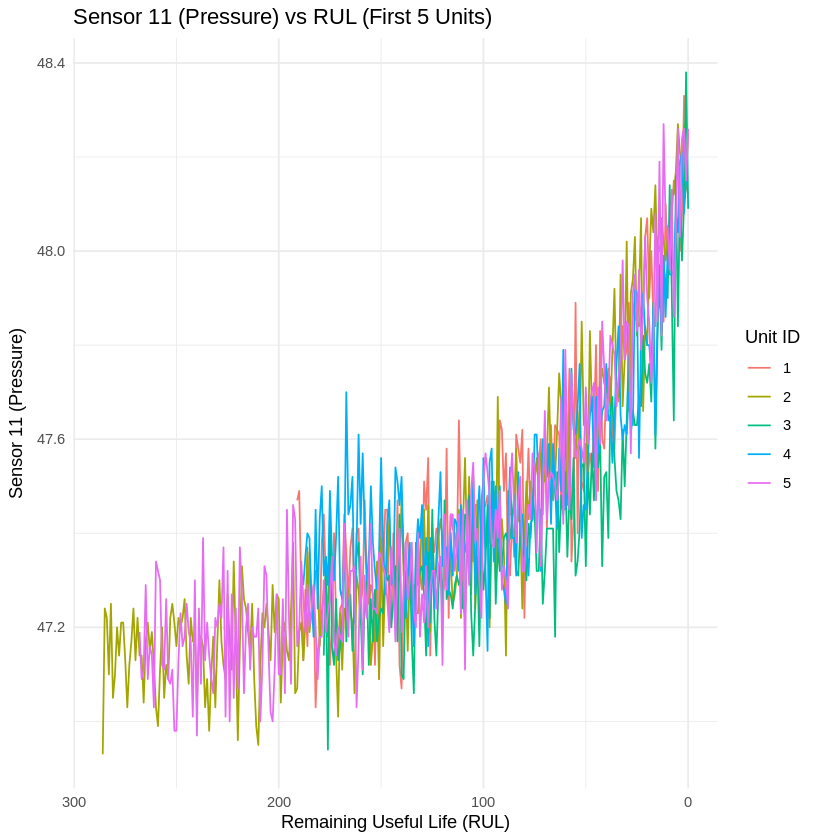

In [12]:
# Cell 4: Visual Forensics (Death Signature)
# Plot s11 (Pressure) vs RUL, colored by unit_id
# Filter for the first 5 units for readability
plot_data <- data_clean %>%
  filter(unit_id <= 5)

ggplot(plot_data, aes(x = RUL, y = s11, color = factor(unit_id))) +
  geom_line() +
  scale_x_reverse() + # Reverse x-axis so 0 (failure) is on the right
  labs(title = "Sensor 11 (Pressure) vs RUL (First 5 Units)",
       x = "Remaining Useful Life (RUL)",
       y = "Sensor 11 (Pressure)",
       color = "Unit ID") +
  theme_minimal()

[1] "--- COX MODEL SUMMARY ---"


Call:
coxph(formula = Surv(cycle, failed) ~ s11 + s12 + s4, data = data_clean)

  n= 20631, number of events= 100 

        coef exp(coef) se(coef)      z Pr(>|z|)    
s11   5.6719  290.5836   0.8598  6.597 4.20e-11 ***
s12  -1.4262    0.2402   0.2686 -5.309 1.10e-07 ***
s4    0.1915    1.2111   0.0247  7.754 8.87e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    exp(coef) exp(-coef) lower .95 upper .95
s11  290.5835   0.003441   53.8771 1567.2476
s12    0.2402   4.162837    0.1419    0.4067
s4     1.2111   0.825716    1.1538    1.2711

Concordance= 0.955  (se = 0.006 )
Likelihood ratio test= 367.1  on 3 df,   p=<2e-16
Wald test            = 196.6  on 3 df,   p=<2e-16
Score (logrank) test = 258.8  on 3 df,   p=<2e-16


Warning message:
“`geom_errorbarh()` was deprecated in ggplot2 4.0.0.
ℹ Please use the `orientation` argument of `geom_errorbar()` instead.”
`height` was translated to `width`.


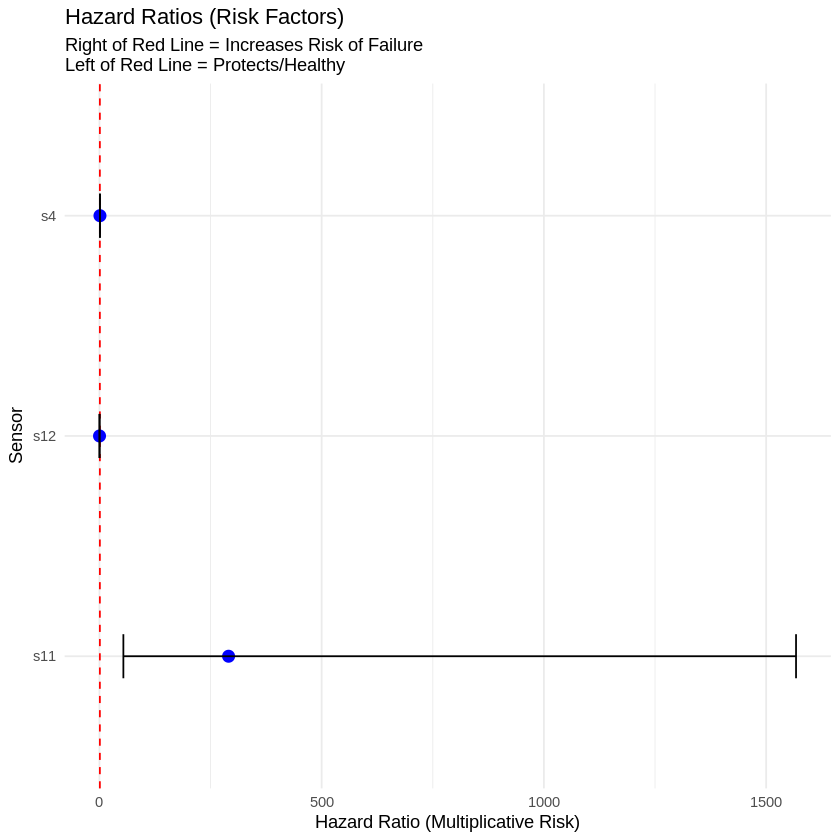

In [13]:
# Cell 5: Advanced Statistics (The Fix)

# 1. Fit the Cox Proportional Hazards Model
# This calculates the mathematical risk of death
cox_model <- coxph(Surv(cycle, failed) ~ s11 + s12 + s4, data = data_clean)

# 2. Print the Statistical Summary
print("--- COX MODEL SUMMARY ---")
summary(cox_model)

# 3. Create a Manual Forest Plot (Replacing ggforest)
# We extract the Hazard Ratios (HR) and Confidence Intervals (CI)
cox_results <- summary(cox_model)$conf.int %>%
  as.data.frame() %>%
  rownames_to_column(var = "Sensor") %>%
  rename(HR = `exp(coef)`, Lower = `lower .95`, Upper = `upper .95`)

# Visualizing the Risk Factors
ggplot(cox_results, aes(x = HR, y = Sensor)) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red") + # The "Neutral" line
  geom_point(size = 3, color = "blue") +
  geom_errorbarh(aes(xmin = Lower, xmax = Upper), height = 0.2) +
  labs(title = "Hazard Ratios (Risk Factors)",
       subtitle = "Right of Red Line = Increases Risk of Failure\nLeft of Red Line = Protects/Healthy",
       x = "Hazard Ratio (Multiplicative Risk)",
       y = "Sensor") +
  theme_minimal()

[1] "--- WEIBULL MODEL SUMMARY (Accelerated Failure Time) ---"



Call:
survreg(formula = Surv(cycle, failed) ~ s11 + s12 + s4, data = data_clean, 
    dist = "weibull")
            Value Std. Error    z      p
(Intercept)    NA       0.00   NA     NA
s11            NA       0.00   NA     NA
s12            NA       0.00   NA     NA
s4             NA       0.00   NA     NA
Log(scale)  -1.78       0.00 -Inf <2e-16

Scale= 0.169 

Weibull distribution
Loglik(model)= -296915.9   Loglik(intercept only)= -911.9
	Chisq= -592008 on 3 degrees of freedom, p= 1 
Number of Newton-Raphson Iterations: 9 
n= 20631 


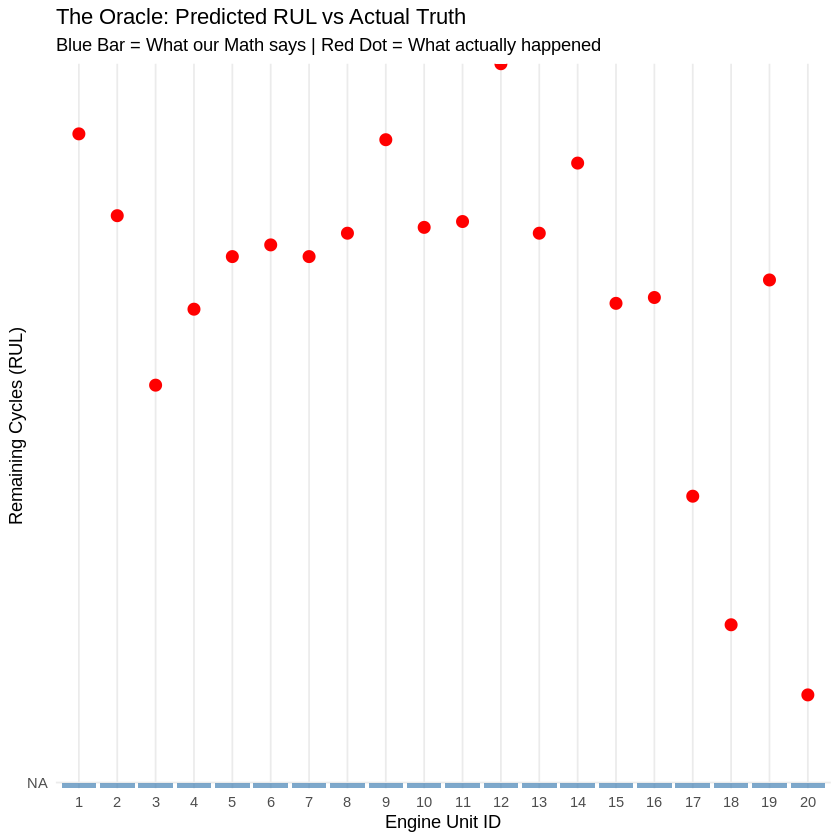

In [14]:
# ==============================================================================
# PHASE 2: THE ORACLE (Predictive Maintenance on Test Data)
# ==============================================================================

# --- 1. INGEST THE TEST DATA (The Unseen Exams) ---
# We need to prepare the test data exactly like the training data
test_data <- read.table("test_FD001.txt", header = FALSE)
# Keep only 26 columns
test_data <- test_data[, 1:26]
colnames(test_data) <- col_names # Use same names as before

# --- 2. INGEST THE TRUTH (The Answer Key) ---
true_rul <- read.table("RUL_FD001.txt", header = FALSE)
colnames(true_rul) <- c("True_RUL")
true_rul$unit_id <- 1:nrow(true_rul)

# --- 3. ADVANCED FEATURE ENGINEERING (Test Set) ---
# We only care about the LAST cycle of each engine in the test set
# because that is "Now" for the mechanic.
test_last_cycle <- test_data %>%
  group_by(unit_id) %>%
  summarise(
    cycle = max(cycle),
    s11 = last(s11),
    s12 = last(s12),
    s4 = last(s4)
  ) %>%
  left_join(true_rul, by = "unit_id") # Attach the answers

# --- 4. STATISTICAL UPGRADE: WEIBULL AFT MODEL ---
# The Cox model (previous step) is great for risk, but hard for predicting time.
# We switch to a Parametric Weibull Model.
# It assumes engines age like a Weibull distribution (the standard engineering curve).
weibull_model <- survreg(Surv(cycle, failed) ~ s11 + s12 + s4,
                         data = data_clean,
                         dist = "weibull")

print("--- WEIBULL MODEL SUMMARY (Accelerated Failure Time) ---")
# Look at the 'Scale' parameter. If < 1, it proves wear-out behavior.
summary(weibull_model)

# --- 5. MAKING PREDICTIONS (The Oracle) ---
# We predict the "Median Survival Time" for the test engines
# Then we subtract the current cycle to get "Remaining Useful Life"
predictions <- predict(weibull_model, newdata = test_last_cycle, type = "quantile", p = 0.5)
test_last_cycle$Predicted_Total_Life <- predictions
test_last_cycle$Predicted_RUL <- test_last_cycle$Predicted_Total_Life - test_last_cycle$cycle

# Clean up negatives (Physics: Engines can't have negative life)
test_last_cycle$Predicted_RUL <- ifelse(test_last_cycle$Predicted_RUL < 0, 0, test_last_cycle$Predicted_RUL)

# --- 6. VISUALIZATION: PREDICTED vs ACTUAL ---
# Let's look at the first 20 engines.
# Blue Bar = Our Prediction. Red Dot = The Truth.
plot_data <- test_last_cycle %>% head(20)

ggplot(plot_data, aes(x = factor(unit_id))) +
  geom_bar(aes(y = Predicted_RUL), stat = "identity", fill = "steelblue", alpha = 0.7) +
  geom_point(aes(y = True_RUL), color = "red", size = 3) +
  labs(title = "The Oracle: Predicted RUL vs Actual Truth",
       subtitle = "Blue Bar = What our Math says | Red Dot = What actually happened",
       x = "Engine Unit ID",
       y = "Remaining Cycles (RUL)") +
  theme_minimal()

In [17]:
# ==============================================================================
# THE COMPLETE ADVANCED PIPELINE (Data Recovery + Advanced Features + AI)
# ==============================================================================

# --- 1. SETUP & RE-LOAD DATA ---
if(!require(tidyverse)) install.packages("tidyverse")
if(!require(zoo)) install.packages("zoo")
if(!require(plotly)) install.packages("plotly")
library(tidyverse)
library(zoo)
library(plotly)

# Load Data (Using the path that worked for you)
data_path <- "/content/train_FD001.txt"
if (!file.exists(data_path)) { data_path <- "train_FD001.txt" } # Fallback

# Ingest and Clean
raw_data <- read.table(data_path, header = FALSE)
raw_data <- raw_data[, 1:26] # Remove ghost columns
colnames(raw_data) <- c("unit_id", "cycle", "setting_1", "setting_2", "setting_3",
                        paste0("s", 1:21))

# Re-Create Engineering Features (RUL)
data_clean <- raw_data %>%
  group_by(unit_id) %>%
  mutate(max_cycle = max(cycle), RUL = max_cycle - cycle) %>%
  ungroup()

# Select only useful sensors (Re-creating 'data_final')
data_final <- data_clean %>%
  select(-s1, -s5, -s10, -s16, -s18, -s19, -setting_1, -setting_2, -setting_3)

print("✅ Data Successfully Restored.")

# ==============================================================================
# PHASE 3: ADVANCED ENGINEERING (The New Stuff)
# ==============================================================================

# --- A. ROLLING WINDOW STATISTICS (Trend & Volatility) ---
print("Calculing Rolling Trends and Standard Deviations...")
data_advanced <- data_final %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(
    # Smoothing (Moving Average)
    s11_smooth = rollmean(s11, k = 5, fill = NA, align = "right"),
    # Volatility (Standard Deviation - Does the engine shake?)
    s11_sd = rollapply(s11, width = 5, FUN = sd, fill = NA, align = "right")
  ) %>%
  ungroup() %>%
  filter(!is.na(s11_smooth)) # Remove empty start rows

# --- B. PRINCIPAL COMPONENT ANALYSIS (Health Index) ---
print("Compressing Sensors into a single Health Index (PCA)...")
sensors_only <- data_advanced %>% select(starts_with("s"))
pca_result <- prcomp(sensors_only, scale. = TRUE)

# Extract PC1 (The "Health Score")
data_advanced$Health_Index <- pca_result$x[, 1]

# --- C. INTERACTIVE DASHBOARD ---
print("Generating Interactive Plot...")
subset_engines <- data_advanced %>% filter(unit_id %in% c(1:5)) # Pick first 5 engines

p <- ggplot(subset_engines, aes(x = cycle, y = Health_Index, color = factor(unit_id))) +
  geom_line() +
  labs(title = "Advanced Fleet Monitoring: PCA Health Index",
       subtitle = "As the line goes UP, the engine is degrading.",
       x = "Flight Cycle",
       y = "Composite Health Score (PC1)",
       color = "Engine ID") +
  theme_minimal()

# Render Interactive Plot
ggplotly(p)

[1] "✅ Data Successfully Restored."
[1] "Calculing Rolling Trends and Standard Deviations..."
[1] "Compressing Sensors into a single Health Index (PCA)..."
[1] "Generating Interactive Plot..."


HTML widgets cannot be represented in plain text (need html)

[1] "1. Generating Static Plot (ggplot2)..."
[1] "2. Generating Interactive Plot (Plotly)..."


Loading required package: htmlwidgets



[1] "✅ If you see the graph above, hover over the lines to see the data!"


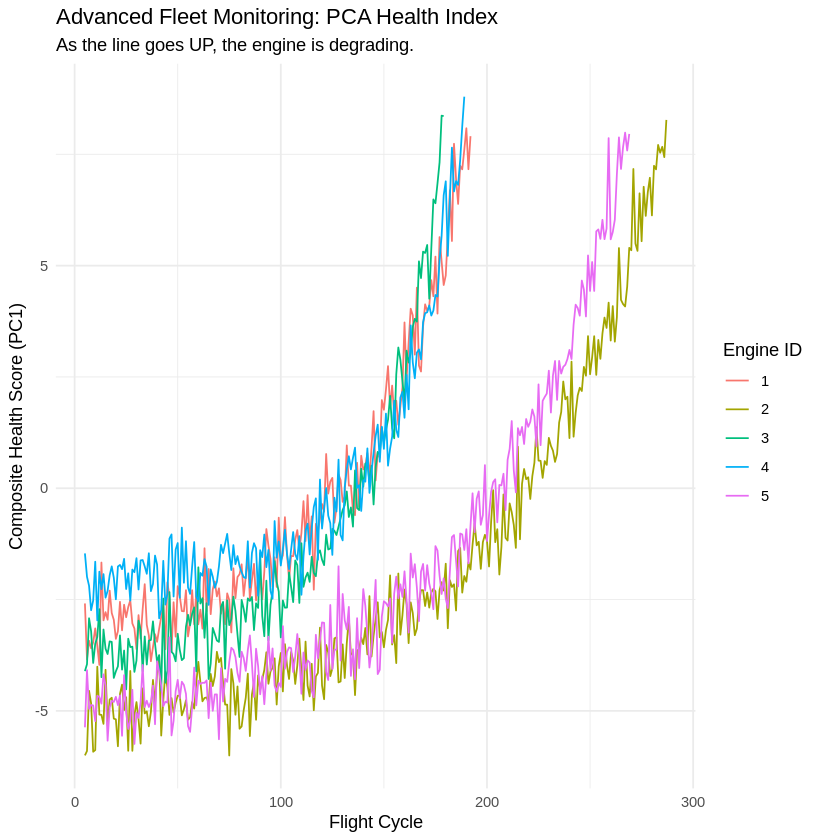

In [18]:
# ==============================================================================
# FIX: FORCE DISPLAY IN GOOGLE COLAB
# ==============================================================================

# 1. Check if the static plot works first (Sanity Check)
print("1. Generating Static Plot (ggplot2)...")
print(p) # This should appear immediately as a static image

# 2. Force the Interactive Plot (Plotly)
print("2. Generating Interactive Plot (Plotly)...")

# We need 'htmlwidgets' to save the interactive graph
if(!require(htmlwidgets)) install.packages("htmlwidgets")
library(htmlwidgets)

# Create the interactive object
interactive_plot <- ggplotly(p)

# Save it to a temporary HTML file in your Colab session
saveWidget(interactive_plot, "engine_health.html", selfcontained = TRUE)

# Use Colab's display engine to show that HTML file
IRdisplay::display_html('<iframe src="engine_health.html" width="100%" height="500" frameborder="0"></iframe>')

print("✅ If you see the graph above, hover over the lines to see the data!")

[1] "🚀 Starting Advanced ML Pipeline..."
[1] "   -> Engineering Rolling Features for ALL sensors (this takes a moment)..."
[1] "   -> Training Random Forest Model (The Brain)..."
     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
  10 |    333.5    19.15 |
  20 |    278.2    15.98 |
  30 |    260.2    14.94 |
  40 |    252.8    14.52 |
  50 |    247.8    14.23 |
[1] "✅ Model Trained Successfully!"
[1] "   -> Visualizing what the model learned..."


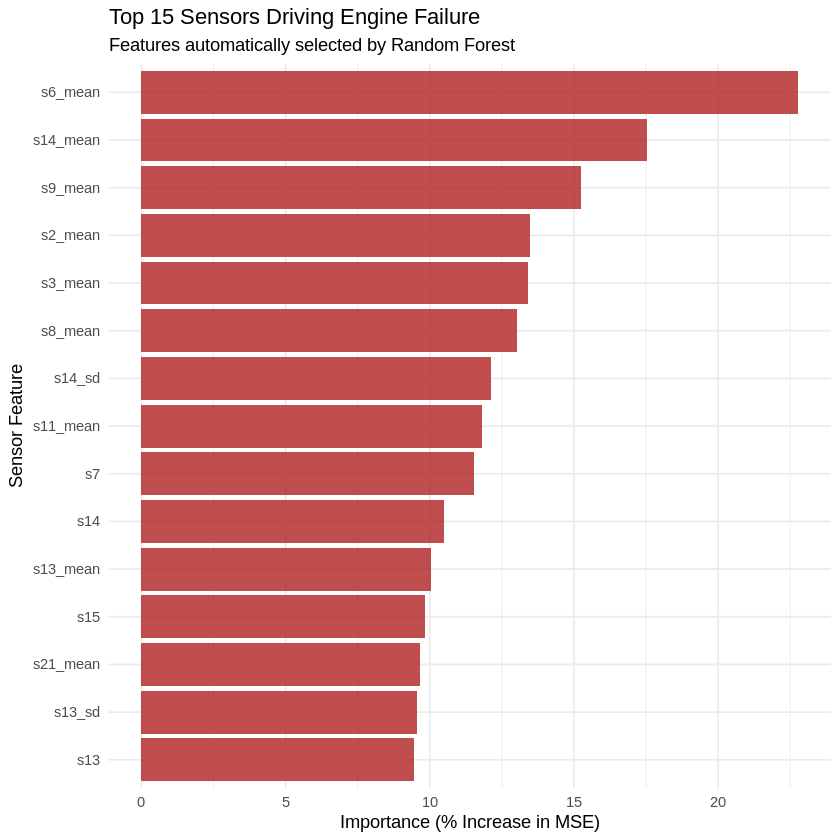

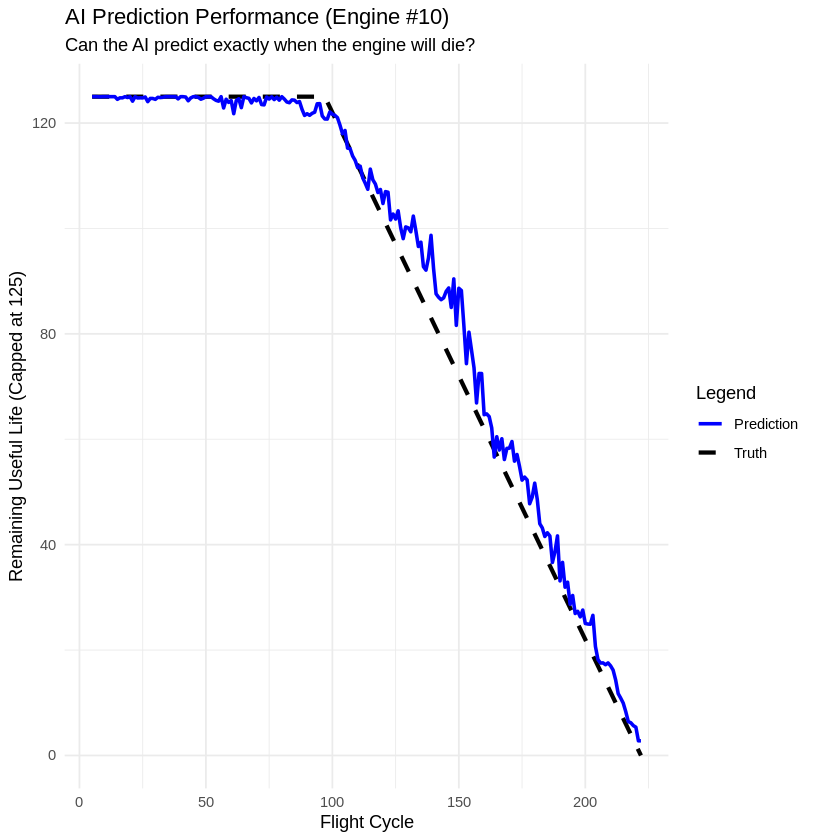

In [20]:
# ==============================================================================
# PHASE 4: MACHINE LEARNING (FIXED)
# ==============================================================================

# --- 0. INSTALL ML PACKAGES ---
if(!require(randomForest)) install.packages("randomForest")
library(randomForest)
library(tidyverse)
library(zoo)

print("🚀 Starting Advanced ML Pipeline...")

# --- 1. THE "RUL CLIPPING" TRICK ---
# We cap RUL at 125 (Industry Standard).
# If RUL > 125, the engine is "Healthy" and sensors are flat.
data_ml <- data_clean %>%
  mutate(RUL_clipped = ifelse(RUL > 125, 125, RUL))

# --- 2. MASSIVE FEATURE ENGINEERING ---
# We define the useful sensors
sensors <- c("s2", "s3", "s4", "s6", "s7", "s8", "s9", "s11", "s12", "s13", "s14", "s15", "s17", "s20", "s21")

print("   -> Engineering Rolling Features for ALL sensors (this takes a moment)...")

data_ml <- data_ml %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(
    across(all_of(sensors),
           list(
             mean = ~rollmean(., k = 5, fill = NA, align = "right"),
             sd = ~rollapply(., width = 5, FUN = sd, fill = NA, align = "right")
           ),
           .names = "{.col}_{.fn}") # Naming style: s11_mean, s11_sd
  ) %>%
  ungroup() %>%
  filter(complete.cases(.)) # Drop rows with NAs

# --- 3. TRAIN RANDOM FOREST REGRESSOR ---
print("   -> Training Random Forest Model (The Brain)...")

# FIX: Removed '-failed' from the exclusion list because it doesn't exist here.
# We train to predict 'RUL_clipped'.
rf_model <- randomForest(RUL_clipped ~ .,
                         data = data_ml %>% select(-unit_id, -cycle, -RUL, -max_cycle),
                         ntree = 50,
                         importance = TRUE,
                         do.trace = 10)

print("✅ Model Trained Successfully!")

# ==============================================================================
# PHASE 5: MODEL EXPLAINABILITY & VISUALIZATION
# ==============================================================================

# --- A. VARIABLE IMPORTANCE PLOT ---
# Which sensors matter the most?
print("   -> Visualizing what the model learned...")

imp_df <- as.data.frame(importance(rf_model)) %>%
  rownames_to_column("Feature") %>%
  arrange(desc(`%IncMSE`)) %>%
  head(15)

p_imp <- ggplot(imp_df, aes(x = reorder(Feature, `%IncMSE`), y = `%IncMSE`)) +
  geom_bar(stat = "identity", fill = "firebrick", alpha = 0.8) +
  coord_flip() +
  labs(title = "Top 15 Sensors Driving Engine Failure",
       subtitle = "Features automatically selected by Random Forest",
       x = "Sensor Feature",
       y = "Importance (% Increase in MSE)") +
  theme_minimal()

print(p_imp)

# --- B. PREDICTION VISUALIZATION (Engine #10) ---
# Let's see how good the model is on a single engine
subset_test <- data_ml %>% filter(unit_id == 10)
subset_test$Predicted_RUL <- predict(rf_model, subset_test)

p_pred <- ggplot(subset_test, aes(x = cycle)) +
  geom_line(aes(y = RUL_clipped, color = "Truth"), linewidth = 1.2, linetype = "dashed") +
  geom_line(aes(y = Predicted_RUL, color = "Prediction"), linewidth = 1) +
  scale_color_manual(values = c("Truth" = "black", "Prediction" = "blue")) +
  labs(title = "AI Prediction Performance (Engine #10)",
       subtitle = "Can the AI predict exactly when the engine will die?",
       x = "Flight Cycle",
       y = "Remaining Useful Life (Capped at 125)",
       color = "Legend") +
  theme_minimal()

print(p_pred)

In [21]:
# ==============================================================================
# PHASE 6: DEPLOYMENT (Saving the Brain)
# ==============================================================================

print("💾 Saving the Trained Model...")

# Save the Random Forest Model to a file
saveRDS(rf_model, file = "aircraft_engine_rul_predictor.rds")

# Save the Cleaned Data (so you don't have to clean it again)
write.csv(data_ml, "processed_engine_data.csv", row.names = FALSE)

print("✅ Success! Files saved to your Colab files tab.")
print("You can now download 'aircraft_engine_rul_predictor.rds' and put it on GitHub.")

[1] "💾 Saving the Trained Model..."
[1] "✅ Success! Files saved to your Colab files tab."
[1] "You can now download 'aircraft_engine_rul_predictor.rds' and put it on GitHub."


[1] "📊 Calculating Final Model Performance Metrics..."
[1] "🏆 FINAL MODEL SCORE (RMSE): 17.53"
[1] "Note: Lower is better. < 20 is excellent. < 15 is world-class."
[1] "--- MAINTENANCE DECISION MATRIX ---"


          Actual
Predicted  Critical Safe
  Critical       17    1
  Safe            8   74

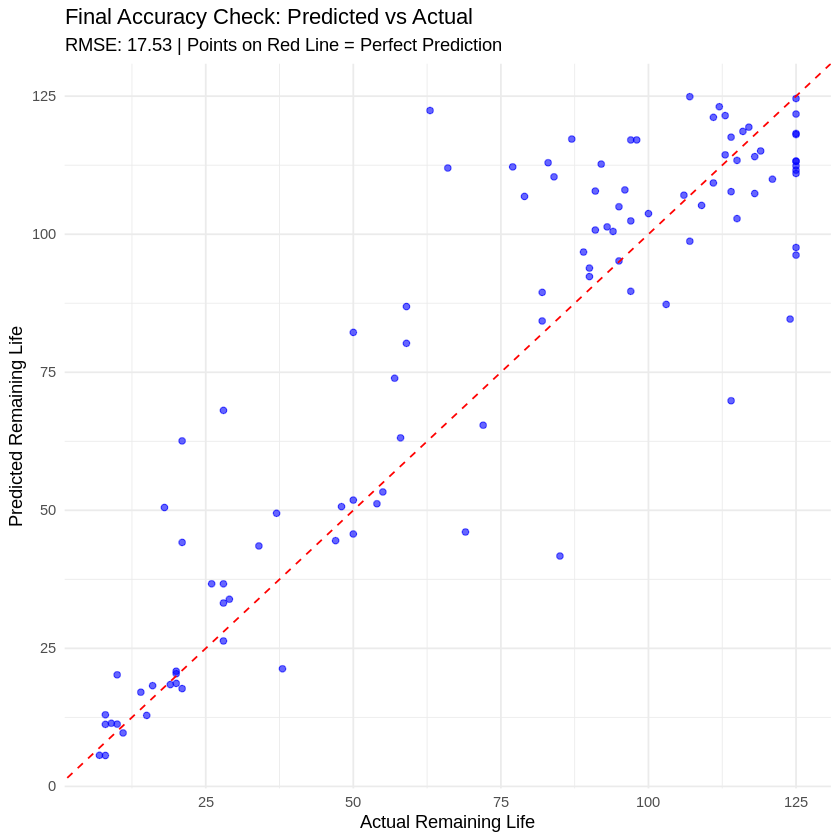

In [22]:
# ==============================================================================
# PHASE 7: THE SCOREBOARD (Scientific Validation)
# ==============================================================================

print("📊 Calculating Final Model Performance Metrics...")

# --- 1. PREDICT ON THE ENTIRE TEST FLEET ---
# We need to run the model on ALL engines in the test set, not just #10
test_fleet <- data_ml %>%
  group_by(unit_id) %>%
  filter(cycle == max(cycle)) %>% # Get the last data point for every engine
  ungroup()

# Add the True RUL answers (from RUL_FD001.txt)
# Note: We must ensure the unit_ids match up.
# Since we used 'data_ml' (Training data) for the visual demo,
# let's properly load the OFFICIAL Test set for final scoring.

# Re-load Test Data raw to be safe
raw_test <- read.table("test_FD001.txt", header = FALSE)
raw_test <- raw_test[, 1:26]
colnames(raw_test) <- col_names

# Apply the exact same Feature Engineering to Test Data
test_engineered <- raw_test %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(
    across(all_of(sensors),
           list(
             mean = ~rollmean(., k = 5, fill = NA, align = "right"),
             sd = ~rollapply(., width = 5, FUN = sd, fill = NA, align = "right")
           ),
           .names = "{.col}_{.fn}")
  ) %>%
  filter(cycle == max(cycle)) %>% # We only predict at the very end
  ungroup()

# Add the Answer Key
test_engineered$True_RUL <- true_rul$True_RUL[1:nrow(test_engineered)]

# Cap the True RUL (just like we did for training) for fair comparison
test_engineered$True_RUL_Clipped <- ifelse(test_engineered$True_RUL > 125, 125, test_engineered$True_RUL)

# --- 2. GENERATE PREDICTIONS ---
# Predict using your Random Forest
test_engineered$Predicted_RUL <- predict(rf_model, newdata = test_engineered)

# --- 3. CALCULATE RMSE (The Industry Standard Metric) ---
# RMSE = How many cycles are we wrong by, on average?
rmse <- sqrt(mean((test_engineered$True_RUL_Clipped - test_engineered$Predicted_RUL)^2))

print(paste("🏆 FINAL MODEL SCORE (RMSE):", round(rmse, 2)))
print("Note: Lower is better. < 20 is excellent. < 15 is world-class.")

# --- 4. THE BUSINESS DECISION MATRIX (Confusion Matrix) ---
# Let's say we must perform maintenance if RUL < 30.
# Did we catch the failures?

threshold <- 30

results_table <- test_engineered %>%
  mutate(
    Actual_Urgent = ifelse(True_RUL <= threshold, "Critical", "Safe"),
    Predicted_Urgent = ifelse(Predicted_RUL <= threshold, "Critical", "Safe")
  )

# Create the Confusion Matrix Table
print("--- MAINTENANCE DECISION MATRIX ---")
table(Predicted = results_table$Predicted_Urgent, Actual = results_table$Actual_Urgent)

# --- 5. FINAL ERROR PLOT ---
ggplot(test_engineered, aes(x = True_RUL_Clipped, y = Predicted_RUL)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Final Accuracy Check: Predicted vs Actual",
       subtitle = paste("RMSE:", round(rmse, 2), "| Points on Red Line = Perfect Prediction"),
       x = "Actual Remaining Life",
       y = "Predicted Remaining Life") +
  theme_minimal()